# How to analyze crystalline data?

First of all, we will generate our data using the datageneration tools **generatecrystaldata** and **disordercrystaldata**.
In this case **fill_volume_fcc** will give us data in the fcc structure and **add_gaussian_noise** will be used to create a noisy version of this data.
For visualization, we will rely on matplolibs scatter plots.

In [ ]:
from datageneration.generatecrystaldata import fill_volume_fcc
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

**fill_volume_fcc(x_limit,y_limit,z_limit)** will fill a 3D volume with the fcc crystal structure. The neighbor distances are normalized to 1.

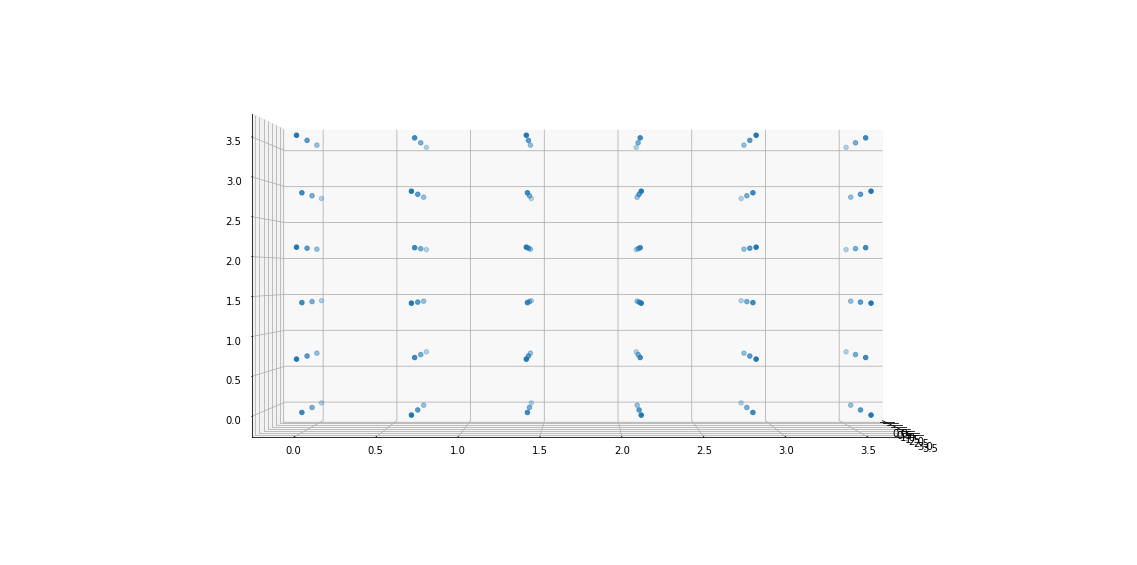

In [78]:
fcc_data=fill_volume_fcc(4,4,4)
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(fcc_data[:,0],fcc_data[:,1],fcc_data[:,2])
ax.view_init(0,0)

## Noisy Data:
**add_gaussian_noise(datapoints, sigma, rnd_seed)** will distort the crystal with gaussian distributed noise (sigma is the width of the gaussian).

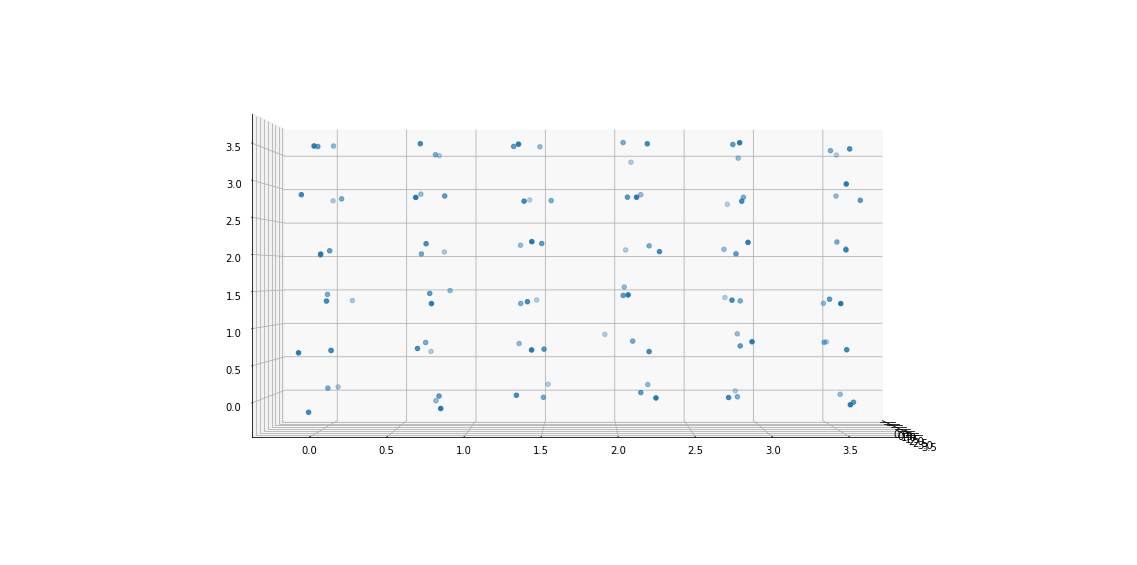

In [80]:
from datageneration.disordercrystaldata import add_gaussian_noise
fcc_data_noise=add_gaussian_noise(fcc_data,0.07,0)
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(fcc_data_noise[:,0],fcc_data_noise[:,1],fcc_data_noise[:,2])
ax.view_init(0,0)

## Calculation of the signature
Before we classify the crystalline data, the signature needs to be calculated. This is done using the **MixedCrystalSignature (MCS)** class.
If you want to use multiple cores to speed up some of the calculations, you can provide the **MCS** with a pool object from the multiprocessing package.
- It is necessary for the MCS that you define the data with **set_datapoints**. 
- A smaller volume than the original data can be defined with **set_inner_volume**. This is useful to mitigate errors at the border of the dataset.
- Finally the signature will be calculated using **calc_signature**.
- The result is a pandas dataframe in **mcs.signature**

In [69]:
from mixedcrystalsignature import MixedCrystalSignature
mcs=MixedCrystalSignature()
mcs.set_datapoints(fcc_data)
mcs.set_inner_volume([[1,3],[1,3],[1,3]])
mcs.calc_signature()
mcs.signature.head()

,N,ba0,ba1,ba2,ba3,ba4,ba5,ba6,ba7,q4,...,dist2,dist3,dist4,dist5,dist6,dist7,dist8,dist9,dist10,dist11
0,12,6,0,0,24,12,0,24,0,0.190941,...,24,0,0,12,0,24,0,6,0,0
1,12,6,0,0,24,12,0,24,0,0.190941,...,24,0,0,12,0,24,0,6,0,0
2,12,6,0,0,24,12,0,24,0,0.190941,...,24,0,0,12,0,24,0,6,0,0
3,12,6,0,0,24,12,0,24,0,0.190941,...,24,0,0,12,0,24,0,6,0,0
4,12,6,0,0,24,12,0,24,0,0.190941,...,24,0,0,12,0,24,0,6,0,0


We can do the same calculation with the noisy data

In [70]:
mcs.set_datapoints(fcc_data_noise)
mcs.set_inner_volume([[0,4],[0,4],[0,4]])
mcs.calc_signature()
mcs.signature.head()

,N,ba0,ba1,ba2,ba3,ba4,ba5,ba6,ba7,q4,...,dist2,dist3,dist4,dist5,dist6,dist7,dist8,dist9,dist10,dist11
0,10,2,0,2,12,11,0,16,2,0.556769,...,7,0,0,0,0,0,0,0,0,0
1,14,4,1,6,29,18,1,32,0,0.241014,...,14,16,4,5,7,16,16,5,4,4
2,15,4,1,8,32,21,2,37,0,0.239583,...,17,17,2,8,13,19,11,7,6,2
3,15,6,0,4,33,26,1,34,1,0.232852,...,16,17,5,4,11,22,11,5,11,3
4,13,6,0,2,28,14,1,27,0,0.202015,...,10,15,4,5,11,16,9,2,3,2


## Classification of the crystal structures
To predict the crystal structures, the pre-trained [standardscaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) and [mlpclassifier](http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html) from [sklearn](http://scikit-learn.org/) are loaded with pickle.

In [66]:
import pickle
with open('./pretrained/standardscaler.pkl',mode='rb') as f:
    scaler=pickle.load(f)
with open('./pretrained/mlpclassifier.pkl',mode='rb') as f:
    classifier=pickle.load(f)

The prediction will return an integer for every datapoint that is recognized as *solid*. The meaning of the integers is defined in crystalanalysis.py and is normally:
- fcc: 1
- hcp: 2
- bcc: 3

Scaling the signature with **scaler.transform** before passing it to **classifier.predict** is crucial for the mlpclassifier (There are also classifiers, which are insensitive to scaling)

In [67]:
prediction=classifier.predict(scaler.transform(mcs.signature))
np.mean(prediction)

1.0

The result of the noisy data is 100% fcc - just as expected. 

Let us plot the analyzed datapoints with the help of **mcs.solid_indices** (this returns an array of indices that belong to the datapoints recognized as solid-like)

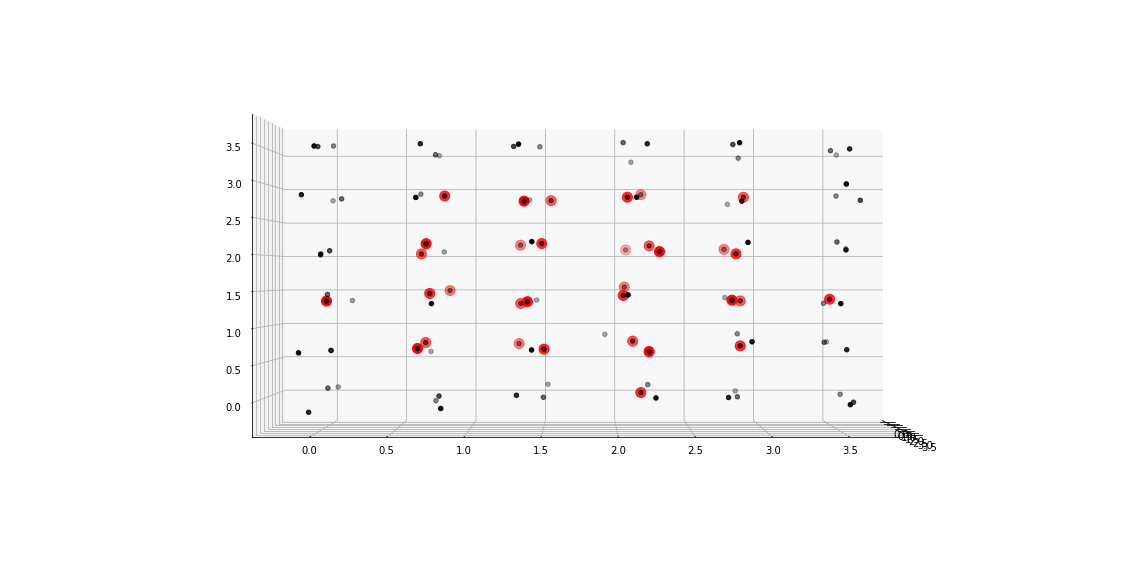

In [77]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(fcc_data_noise[:,0],fcc_data_noise[:,1],fcc_data_noise[:,2],marker='o',color='black')
solid_data=mcs.datapoints[mcs.solid_indices]
ax.scatter(solid_data[:,0],solid_data[:,1],solid_data[:,2],color='red',s=100)
ax.view_init(0,0)

If you have multiple crystal structures in the dataset, just plot the results for all labels. 